In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import os, sys, time
from termcolor import *
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN

# set working dir
working_dir = 'H:\\UGA MASTERS\\Data Science Comp'
os.chdir(working_dir)
from project_tools import load_obj, interact, save_obj

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:

In [2]:
"""
Nested Cross Val
    Random Forest Classifier and Logistic Regression Classifier
"""
# manual nested cross-validation for random forest on a classification dataset

def NCV(X,y, model_name='rf'):
    # configure the cross-validation
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        
        # define the model
        if model_name == 'rf':
            print(f'Initializing Random Forest Classifier')
            model = RandomForestClassifier(random_state=1)
            # define search space
            space = {'bootstrap': [True, False],
                     'max_depth': [1,2,4,6,8,10],
                     'max_features': ['auto'],
                     'min_samples_leaf': [1, 2, 4],
                     'min_samples_split': [2, 5, 10],
                     'n_estimators': [10, 50 , 100, 200, 600]}
        else:
            print(f'Initializing Logistic Regression Classifier')
            penalty = ['l1', 'l2']
            # Create regularization hyperparameter space
            C = np.logspace(-10, 4, 20)
            solver = ['newton-cg', 'lbfgs', 'liblinear']
            # Create hyperparameter options
            space = dict(C=C, penalty=penalty, solver=solver)
            model = LogisticRegression()
            
        # define GS use AUC for scoring
        search = GridSearchCV(model, space, scoring='roc_auc', cv=cv_inner, refit=True, n_jobs=-1,  verbose=3)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        # store the result
        outer_results.append(acc)
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
    return best_model

    
"""
XGBoost model
"""
def fast_boost(X_train, y_train, X_test, y_test, X_val, y_val):
        # https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf
    from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
    space = {
        'max_depth' : hp.choice('max_depth', range(1, 14, 1)),
        'learning_rate' : hp.quniform('learning_rate', 0.01, 0.8, 0.01),
        'n_estimators' : hp.choice('n_estimators', range(10, 2000, 5)),
        'gamma' : hp.quniform('gamma', 0.1, 1, 0.01),
        'min_samples_split': hp.choice('min_samples_split', range(1, 20, 1)),
        'min_samples_leaf':  hp.choice('min_samples_leaf', range(1, 8, 1)),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
        'subsample' : hp.quniform('subsample', 0.01, 0.5, 0.01),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.01, 0.5, 0.01)}

    def objective(space):
        classifier = xgb.XGBClassifier(
#             scale_pos_weight=1, 
            eval_metric='aucpr', 
            objective='binary:logistic',
            n_estimators = space['n_estimators'],
                                max_depth = int(space['max_depth']),
                                learning_rate = space['learning_rate'],
                                gamma = space['gamma'],
                                min_child_weight = space['min_child_weight'],
                                subsample = space['subsample'],
                                colsample_bytree = space['colsample_bytree'],
                                min_samples_leaf =space['min_samples_leaf']
                                )
        
        eval_set = [(X_val, y_val)]
        classifier.fit(X_train, y_train, 
                       eval_metric='aucpr', 
#                        sample_weight=(y_train.values*36)+1,
                       early_stopping_rounds=5,
                       eval_set=eval_set,
                       verbose=False)

        # Applying k-Fold Cross Validation
        from sklearn.model_selection import cross_val_score
        accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 12)
        CrossValMean = accuracies.mean()
        CrossValVar = accuracies.var()
        
        print("CrossValMean:", CrossValMean)
        print("CrossValVar:", CrossValVar)

        return{'loss':1-CrossValMean, 'status': STATUS_OK }
    ###################################################
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)

    print("Best: ", best)
    ###################################################

    from xgboost import XGBClassifier
    XGBmodel = xgb.XGBClassifier(
                                eval_metric='aucpr', 
                                objective='binary:logistic', 
                                n_estimators = best['n_estimators'],
                                max_depth = best['max_depth'],
                                learning_rate = best['learning_rate'],
                                gamma = best['gamma'],
                                min_child_weight = best['min_child_weight'],
                                subsample = best['subsample'],
                                colsample_bytree = best['colsample_bytree'],
                                min_samples_leaf =best['min_samples_leaf'],
                                min_samples_split = best['min_samples_split'])
    

    XGBmodel.fit(X_train, y_train, eval_metric='aucpr')
    return XGBmodel, best




"""
data viz
"""
def Modeltest(X_test, y_test, y_pred, model, model_name, SVM = False):
    f1 = round(f1_score(y_test, y_pred, average="macro"), 3 )
    print('F1 Score: ', f1)
    ps = round(precision_score(y_test, y_pred, average="macro") * 100, 2 )
    print('precision Score: ', ps)
    rs = round(recall_score(y_test, y_pred, average="macro") * 100, 2 )
    print('Recall Score: ', rs)
    acc_nb = round(metrics.accuracy_score(y_test, y_pred) * 100, 2 )
    print('Total Accuracy: ', acc_nb )
    if SVM == True:
        roc = 'NaN'
    else:
        y_pred = model.predict_proba(X_test)[:, 1]
        roc = round(roc_auc_score(y_test,y_pred), 3 )
        print('ROC AUC Score : ',roc)
        
    score_table[model_name] = [f1, ps, rs, acc_nb, roc]
    score_table.index = ['F1 Score','precision Score','Recall Score','Total Accuracy','ROC_AUC Score']
    return np.array([f1, ps, rs, acc_nb, roc])

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report


from sklearn.metrics import confusion_matrix
def draw_cm(actual, predicted):
    cm = confusion_matrix( actual, predicted, [1,0]).T
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Yes","No"] , yticklabels = ["Yes","No"] )
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()
    
    
def test_results(model,X_train, y_train, X_test, y_test, name='XGBoost hyperopt'):
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 2)
    CrossValMean = accuracies.mean()
    print("Final CrossValMean: ", CrossValMean)

    CrossValSTD = accuracies.std()
    y_pred = model.predict(X_test)
    
#     draw_cm(y_test, y_pred)
    acc_nb = round(metrics.accuracy_score(y_test, y_pred) * 100, 2 )
    print('Total Accuracy: ', acc_nb )
    
    from sklearn.metrics import confusion_matrix
    confusion = confusion_matrix(y_test, y_pred)
    
    print('Confusion Matrix\n')
    print(confusion)
    #importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2']))
    
    draw_cm(y_test, y_pred)
    return classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2'])

In [3]:
"""
data preprocess for train and test
"""
# one hot encode states
def OneHot(NewName, oldName, df, exceptions=[]):
    uniqueL = df[str(oldName)].unique()
    for item in uniqueL:
        if (item in exceptions):
            df[str(NewName) + '_Other'] =  np.where(df[str(oldName)] == str(item), 1, 0)
        else:
            df[str(NewName) + '_' + str(item)] =  np.where(df[str(oldName)] == str(item), 1, 0)
    df = df.drop([str(oldName)], axis = 1)
    return df

def preprocess_data(file_path):
    # load training data
    df = pd.read_csv(file_path)
    df.head()
    # only cols with Na are uti_card_50plus_pct, rep_income
    
    print(f'There are a total of {len(df)} rows of data.')
    
    
    print(f'\n\nMissing data:\n{df.isna().sum()}\n\n')
    
    print(colored(f'Filling NaN data and one-hot encoding data....', 'blue'))
    """
    NaN may be different from 0.
    E.G. if someone reports 0 income it is not the same as 
    not being sure about a person’s income, to account for this we 
    did not just fill NaN with zeros, first we generated a column to denote
    if it was NaN to differentiate true zero from NaN
    """
    df['uti_card_50plus_pct_NA'] = df.uti_card_50plus_pct.map(lambda x: 1 if np.isnan(x) else 0)
    df['rep_income_NA'] = df.rep_income.map(lambda x: 1 if np.isnan(x) else 0)
    df.uti_card_50plus_pct = df.uti_card_50plus_pct.fillna(0) # fill na
    df.rep_income = df.rep_income.fillna(0) # fill na
    df = OneHot('State', 'States', df)
    print(f'\n\nMissing data after fill:\n{df.isna().sum()}\n\n')
    return df


def random_over_under(df, under_fract=1, over_fract=1):
    print('---------------------------------------------------------\nbalance uneven dataset random oversample')
    print(df.Default_ind.value_counts())
    ratio = df.Default_ind.value_counts()[0]/df.Default_ind.value_counts()[1]
    print(colored('\n\nthe ratio of Default_ind 1 to 0 is: ', None), colored(f'{round(ratio,3)}', 'red'))

    df_0 = df[df.Default_ind==0]
    df_1 = df[df.Default_ind==1]
    
    df_0 = df_0.sample(frac=under_fract, replace=False)
    
#     df_1_samples = df_1

    df_1_samples = df_1.sample(n=int(len(df_0)*over_fract), replace=True, random_state=19)

    df_resampled = pd.concat([df_1_samples,df_0])

    print(f'\n\n---------------------------------------------------------\n{df_resampled.Default_ind.value_counts()}')
    ratio = df_resampled.Default_ind.value_counts()[0]/df_resampled.Default_ind.value_counts()[1]
    print(colored('\n\nthe ratio of Default_ind 1 to 0 is: ', None), colored(f'{ratio}', 'red'))
    return df_resampled

In [4]:
"""
Load Data
"""

print(colored('Loading and preprocess training data....', 'red'))
train_data = preprocess_data('data/Simulated_Data_Train.csv')
print(colored('Done loading and preprocess training data!', 'red'))

print(colored('Loading and preprocess testing data....', 'red'))
test_data = preprocess_data('data/Simulated_Data_Test.csv')
print(colored('Done loading and preprocess test data!', 'red'))

print(colored('Loading and preprocess val data....', 'red'))
val_data = preprocess_data('data/Simulated_Data_Validation.csv')
print(colored('Done loading and preprocess val data!', 'red'))

print('Fix column order')
test_data = test_data[train_data.columns]

print(colored('Random oversampling training data...', 'green'))
resampled_train_data_Rand = random_over_under(train_data, over_fract=1.05, under_fract=0.3)

"""
load val data
"""
val_data_1 = val_data[val_data['Default_ind']==1]
val_data_0 = val_data[val_data['Default_ind']==0].sample(n=int(len(val_data_1)), replace=False, random_state=19)

Val_resampled = pd.concat([val_data_1, val_data_0])
Val_resampled['Default_ind'].value_counts()

X_val = Val_resampled.drop('Default_ind',1)
y_val = Val_resampled['Default_ind']

Loading and preprocess training data....
There are a total of 20000 rows of data.


Missing data:
tot_credit_debt                          0
avg_card_debt                            0
credit_age                               0
credit_good_age                          0
card_age                                 0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_ 36_month_num                  0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
rep_income                            1570
States                                   0
Default_ind                              0

CrossValMean:                                         
0.8274468691398408                                    
CrossValVar:                                          
5.7360161452366186e-05                                
CrossValMean:                                                                    
0.8333641319325867                                                               
CrossValVar:                                                                     
0.00015001046139517346                                                           
CrossValMean:                                                                    
0.7454980685814596                                                               
CrossValVar:                                                                     
8.311433891679521e-05                                                            
CrossValMean:                                                                    
0.7379058862208003                        

CrossValMean:                                                                     
0.9239684622343646                                                                
CrossValVar:                                                                      
6.207826419164119e-05                                                             
CrossValMean:                                                                     
0.9184054301394157                                                                
CrossValVar:                                                                      
0.0001085625019772312                                                             
CrossValMean:                                                                     
0.9199065108051597                                                                
CrossValVar:                                                                      
7.988914032583165e-05                                                             
Cros

CrossValVar:                                                                      
4.77303444359002e-05                                                              
100%|██████████| 50/50 [33:53<00:00, 34.06s/trial, best loss: 0.06596545089898209]
Best:  {'colsample_bytree': 0.49, 'gamma': 0.24, 'learning_rate': 0.67, 'max_depth': 11, 'min_child_weight': 1.0, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 264, 'subsample': 0.45}
Final CrossValMean:  0.8716001412928294
Total Accuracy:  83.98
Confusion Matrix

[[4036  563]
 [ 238  163]]

Accuracy: 0.84

Micro Precision: 0.84
Micro Recall: 0.84
Micro F1-score: 0.84

Macro Precision: 0.58
Macro Recall: 0.64
Macro F1-score: 0.60

Macro Precision: 0.58
Macro Recall: 0.64
Macro F1-score: 0.60

Macro Precision: 0.58
Macro Recall: 0.64
Macro F1-score: 0.60

Weighted Precision: 0.89
Weighted Recall: 0.84
Weighted F1-score: 0.86

Classification Report

              precision    recall  f1-score   support

     Class 1       0.9

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


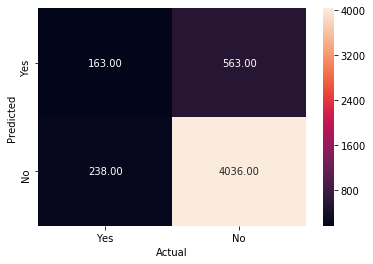

'\nNCV Logit\n'

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

do_pca = True
pca_comp = 5


"""
randomover sample
"""
y_train_rand = resampled_train_data_Rand['Default_ind']
X_train_rand = resampled_train_data_Rand.drop('Default_ind',1)

# df_1 = resampled_train_data_Rand[resampled_train_data_Rand['Default_ind']==1]
# df_0 = resampled_train_data_Rand[resampled_train_data_Rand['Default_ind']==0]
# df_0_sub = df_0.sample(frac=0.1)
# select_df = pd.concat([df_1, df_0_sub])
# y_train_rand = select_df['Default_ind']
# X_train_rand = select_df.drop('Default_ind',1)

y_test = test_data['Default_ind']
X_test = test_data.drop('Default_ind',1)

# Scale
if do_pca:
    pipe = Pipeline([('scale', StandardScaler()),('reduce_dims', PCA(n_components=pca_comp))])
    cols = [x for x in range(pca_comp)]
else:
    pipe = Pipeline([('scale', StandardScaler())])
    cols = X_train_rand.columns
pipe.fit(X_train_rand)
train_scaled = pipe.transform(X_train_rand)
test_scaled = pipe.transform(X_test)
X_val_scaled = pipe.transform(X_val)

train_scaled = pd.DataFrame(train_scaled, columns=cols)
test_scaled = pd.DataFrame(test_scaled, columns=cols)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=cols)


"""
xgboost
"""
XGBmodel_rand, best = fast_boost(train_scaled, y_train_rand, test_scaled, y_test, X_val_scaled, y_val)
# show results
_ = test_results(XGBmodel_rand, train_scaled, y_train_rand, test_scaled, y_test)

"""
Synthetic Data:
    Not used becuase they preformed slightly worse.
"""
# under_fract=0.3
# df_0 = train_data[train_data.Default_ind==0]
# df_1 = train_data[train_data.Default_ind==1]
# df_0 = df_0.sample(frac=under_fract, replace=False)
# df_resampled = pd.concat([df_1,df_0])

# y_train_SUB = df_resampled['Default_ind']
# X_train_SUB = df_resampled.drop('Default_ind',1)
# X_train_SUB  = pipe.transform(X_train_SUB)
# X_train_SUB = pd.DataFrame(X_train_SUB, columns=cols)

# # SMOTE
# sm = SMOTE(random_state=2)
# X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train_SUB, y_train_SUB)
# X_train_SMOTE = pd.DataFrame(X_train_SMOTE, columns=cols)
# print(f'there are a total of: {len(y_train_SMOTE)} and a total set of 1s : {y_train_SMOTE.sum()}')
# # ADASYN
# sm = ADASYN()
# X_train_ADASYN, y_train_ADASYN = sm.fit_sample(X_train_SUB, y_train_SUB)
# X_train_ADASYN = pd.DataFrame(X_train_ADASYN, columns=cols)
# print(f'there are a total of: {len(y_train_ADASYN)} and a total set of 1s : {y_train_ADASYN.sum()}')

"""
xgboost + SMOTE
"""
# XGBmodel_SMOTE, best = fast_boost(X_train_SMOTE, y_train_SMOTE, test_scaled, y_test, X_val_scaled, y_val)
# # show results
# _ = test_results(XGBmodel_SMOTE, X_train_SMOTE, y_train_SMOTE, test_scaled, y_test)
"""
xgboost + ADASYN
"""
# XGBmodel_ADASYN, best_ADASYN = fast_boost(X_train_ADASYN, y_train_ADASYN, test_scaled, y_test, X_val_scaled, y_val)
# # show results
# _ = test_results(XGBmodel_ADASYN, X_train_ADASYN, y_train_ADASYN, test_scaled, y_test)

"""
NCV RF
"""
# rf = NCV(train_scaled.to_numpy(), y_train_rand.to_numpy())

"""
NCV Logit
"""
# logit = NCV(train_scaled.to_numpy(), y_train_rand.to_numpy(), model_name='logit')

# Data Exploration

In [ ]:
"""
How to choose # PCA components
"""
%matplotlib inline
def plot_pca_comp(data):
    f, (ax ) = plt.subplots(1, 1, figsize = (7,4), dpi=100);
    pipe2 = Pipeline([('scale', StandardScaler())])
    pipe2.fit(X_train_rand)
    train_sc = pipe.transform(data)
    pca = PCA().fit(train_sc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components', fontsize=12)
    plt.ylabel('cumulative explained variance', fontsize=12)
    plt.title('PCA Explained Variance',fontsize=16)
    plt.show()
    
plot_pca_comp(X_train_rand)

In [ ]:
"""
SHAP TreeExplainer

if you want feature names you cannot run with PCA. 
Go back and set do_PCA to False
"""
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

%matplotlib inline
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [15, 5]

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact on Defaulting)")
    plt.show()



explainer = shap.TreeExplainer(XGBmodel_rand)
shap_values = explainer.shap_values(train_scaled)
ss = shap.summary_plot(shap_values, train_scaled, plot_type="bar", class_names=XGBmodel_rand.classes_)
plt.show()

explainer = shap.TreeExplainer(XGBmodel_rand) # insert your model
shap_values = explainer.shap_values(train_scaled) # insert your train Pool object
plt.show()
  
ABS_SHAP(shap_values,train_scaled)
shap.summary_plot(shap_values, train_scaled)
plt.show

In [ ]:
"""
Explore how depth effects results
"""

"""
Only considering training data
"""
def get_curves(X_, y_, pars):
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 0.2)
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec

def gen_curves(X_, y_, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_, y_, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

def plot_roc(X_, y_, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_, y_, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
#     ax1.set_xlim([0, 0.0005])
#     ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

# plot_roc(train_scaled, y_train_rand, best, 'max_depth', [1,2,3,4,5,7,10,15])



"""
considering test data
"""
from pylab import rcParams
rcParams['figure.figsize'] = 3, 3
rcParams['axes.labelsize'] = "large"
rcParams['font.size']= 12

def test_bestModel_overMaxDepth(best): # best is a dict of best params
    reports = [] # formatted [cl0 pre, cl0 TPR, cl1 pre, cl1 TPR]
    for depth in range(1,16):
        from xgboost import XGBClassifier
        print(f'\n\n\n\n\n  {depth}')
        XGB = xgb.XGBClassifier(
                                    eval_metric='aucpr', 
                                    objective='binary:logistic', 
                                    n_estimators = best['n_estimators'],
                                    max_depth = depth,
                                    learning_rate = best['learning_rate'],
                                    gamma = best['gamma'],
                                    min_child_weight = best['min_child_weight'],
                                    subsample = best['subsample'],
                                    colsample_bytree = best['colsample_bytree'],
                                    min_samples_leaf =best['min_samples_leaf'])

        XGB.fit(train_scaled, y_train_rand, eval_metric='aucpr')
        report = test_results(XGB, train_scaled, y_train_rand, test_scaled, y_test)
        reports.append([report.split()[6], report.split()[7], report.split()[12], report.split()[13]])
    return reports

reports = test_bestModel_overMaxDepth(best)
pd.DataFrame(np.array(reports).astype(float),
             columns=['Precision Class 1', 'Recall Class 1','Precision Class 2', 'Recall Class 2'],
             index = ['Max depth ' + str(x) for x in range(1,16)])

In [62]:
best = {'colsample_bytree': 0.46,
 'gamma': 0.22,
 'learning_rate': 0.21,
 'max_depth': 5,
 'min_child_weight': 3.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 229,
 'subsample': 0.37}

{'colsample_bytree': 0.34,
 'gamma': 0.68,
 'learning_rate': 0.15,
 'max_depth': 5,
 'min_child_weight': 13.0,
 'min_samples_leaf': 3,
 'min_samples_split': 1,
 'n_estimators': 319,
 'subsample': 0.42}

In [65]:
XGB2 = xgb.XGBClassifier(
                            eval_metric='aucpr', 
                            objective='binary:logistic', 
                            n_estimators = best['n_estimators'],
                            max_depth = 1,
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree'],
                            min_samples_leaf =best['min_samples_leaf'])

XGB2.fit(train_scaled, y_train_rand, eval_metric='aucpr')

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.34, eval_metric='aucpr',
              gamma=0.68, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=1, min_child_weight=13.0,
              min_samples_leaf=3, missing=nan, monotone_constraints=None,
              n_estimators=319, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.42,
              tree_method=None, validate_parameters=False, verbosity=None)

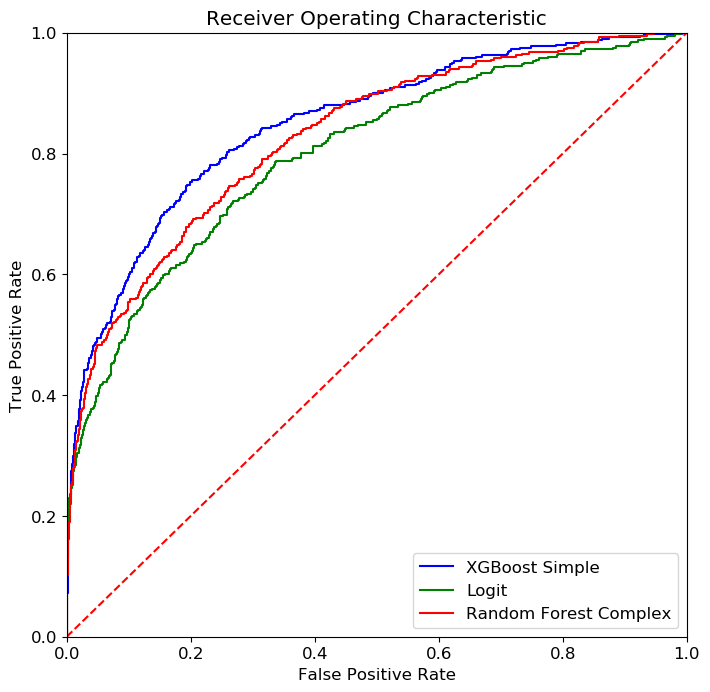

In [70]:
"""
Receiver Operating Characteristic plot gen
"""
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
rcParams['font.size']= 12
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = XGB2.predict_proba(test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'XGBoost Simple')


probs = XGBmodel_rand.predict_proba(test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'pink', label = 'Logit')

probs = logit.predict_proba(test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'Logit')

probs = XGB.predict_proba(test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label = 'Random Forest Complex')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def test_bestModel_overMaxDepth(best): # best is a dict of best params
    reports = [] # formatted [cl0 pre, cl0 TPR, cl1 pre, cl1 TPR]
    for depth in range(1,16):
        from xgboost import XGBClassifier
        print(f'\n\n\n\n\n  {depth}')
        XGB = xgb.XGBClassifier(
                                    eval_metric='aucpr', 
                                    objective='binary:logistic', 
                                    n_estimators = best['n_estimators'],
                                    max_depth = depth,
                                    learning_rate = best['learning_rate'],
                                    gamma = best['gamma'],
                                    min_child_weight = best['min_child_weight'],
                                    subsample = best['subsample'],
                                    colsample_bytree = best['colsample_bytree'],
                                    min_samples_leaf =best['min_samples_leaf'])

        XGB.fit(train_scaled, y_train_rand, eval_metric='aucpr')
        report = test_results(XGB, train_scaled, y_train_rand, test_scaled, y_test)
        reports.append([report.split()[6], report.split()[7], report.split()[12], report.split()[13]])
    return reports

reports = test_bestModel_overMaxDepth(best)

# Testing Viability of Removing Anom 

In [ ]:
"""
k-means Anom
"""
print('K-Means')
pca_comp = 3
pipe = Pipeline([('scale', StandardScaler()),('reduce_dims', PCA(n_components=pca_comp))])
pipe.fit(X_train_rand)
train_scaled = pipe.transform(X_train_rand)
test_scaled = pipe.transform(X_test)
train_scaled = pd.DataFrame(train_scaled,)
test_scaled = pd.DataFrame(test_scaled,)

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
fig = pyplot.figure()
ax = Axes3D(fig)

colors = np.array(['blue', 'red'])
# make and show plot
ax.scatter(train_scaled.iloc[:,0],train_scaled.iloc[:,1], train_scaled.iloc[:,2], c=colors[y_train_rand.values.astype(int)])
plt.show()

# segment data
df_1 = train_data[train_data['Default_ind']==1]
df_0 = train_data[train_data['Default_ind']==0]
df_1.head()

pipe = Pipeline([('scale', StandardScaler())])
pipe.fit(train_data)
train_scaled_1 = pipe.transform(df_1)

# test cluster sizes
%matplotlib inline
from sklearn.cluster import KMeans
def explore_cluster(data):
    score_2 = []
    range_v = range(1,20)
    for i in range_v:
        kmeans = KMeans(n_clusters =i)
        kmeans.fit(data)
        score_2.append(kmeans.inertia_)
    
    plt.plot(range_v, score_2, color='red', marker='o')
    plt.title('Kmeans auto', fontsize=14)
    plt.xlabel('num cluster', fontsize=14)
    plt.ylabel('inertia', fontsize=14)
    plt.grid(True)
    plt.show()
explore_cluster(train_scaled_1)


# select cluster count
kmeans = KMeans(n_clusters = 2)
kmeans.fit(train_scaled_1)


# find the distance from clusters to new VDS data and old CCS data
centroids = kmeans.cluster_centers_
def min_cluster_dist(data_point ,centroids=centroids):
    scores = []
    for center in centroids:
        scores.append((sum((data_point - center)**2))**(1/2))
    return min(scores)

def dist_array(Encoded_data):
    distances = []
    for data_point in Encoded_data:
        distances.append(min_cluster_dist(data_point))
    return distances

def cross_distance(pred_ccs,pred_vds):
    distances = []
    for idx in range(len(pred_ccs)):
        distances.append((sum((pred_ccs[idx] - pred_vds[idx])**2))**(1/2))
    return distances

dist_1 = dist_array(train_scaled_1)
# plot distances 
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(dist_1, bins=80, density=True, label='Cross', alpha=.3, color='blue')

plt.title("Min Distnace from 10 Cluster")
plt.legend()
plt.show()


print('\n\n\nGaussianMixture')
from sklearn.mixture import GaussianMixture
from numpy import quantile, where
def fit_gmm_get_anom_idx(fit_data, predict_data, quant_score=0.15):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(fit_data) # usually CCS
    scores_fitted = gmm.score_samples(fit_data) # when setting thresh score use fit data
    thresh_fitted = quantile(scores_fitted, quant_score)
    
    scores = gmm.score_samples(predict_data)
    thresh = quantile(scores, quant_score)
    
    print(f'thresh_fitted of: {thresh_fitted}')
    print(f'thresh of: {thresh}') 
    index = where(scores <= thresh_fitted)
    values = predict_data[index]
    print(len(values))
    print(len(predict_data))
    try:
        plt.scatter(predict_data[:,0], predict_data[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        plt.show()
    except:
        pass
    return thresh_fitted, scores, values, index

thresh_fitted, scores, values, index = fit_gmm_get_anom_idx(train_scaled_1, train_scaled_1, quant_score=0.05)


outter_idx = ['red' if x in list(index[0]) else 'blue' for x in range(len(train_scaled_1))]
pca_comp = 3
pipe = Pipeline([('scale', StandardScaler()),('reduce_dims', PCA(n_components=pca_comp))])
# pipe = Pipeline([('scale', StandardScaler())])
pipe.fit(train_scaled_1)
train_scaled_1 = pipe.transform(train_scaled_1)

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

colors = np.array(['blue', 'red'])
# make and show plot
ax.scatter(train_scaled_1[:,0],train_scaled_1[:,1], train_scaled_1[:,2],c=outter_idx)
plt.show()

# sub select data
fill = np.zeros((train_scaled_1.shape[0]-len((index[0])), pca_comp))
df_1['idx'] = [x for x in range(len(df_1))]
df_1_select = df_1[~df_1['idx'].isin(list(index[0]))]
select_df = pd.concat([df_1_select, df_0])

best six

{'colsample_bytree': 0.46,
 'gamma': 0.22,
 'learning_rate': 0.21,
 'max_depth': 5,
 'min_child_weight': 3.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 229,
 'subsample': 0.37}

{'colsample_bytree': 0.34,
 'gamma': 0.68,
 'learning_rate': 0.15,
 'max_depth': 5,
 'min_child_weight': 13.0,
 'min_samples_leaf': 3,
 'min_samples_split': 1,
 'n_estimators': 319,
 'subsample': 0.42}

{'colsample_bytree': 0.22,
 'gamma': 0.31,
 'learning_rate': 0.26,
 'max_depth': 6,
 'min_child_weight': 17.0,
 'min_samples_leaf': 2,
 'min_samples_split': 0,
 'n_estimators': 339,
 'subsample': 0.43}
 
 {'colsample_bytree': 0.5,
 'gamma': 0.42,
 'learning_rate': 0.33,
 'max_depth': 9,
 'min_child_weight': 18.0,
 'min_samples_leaf': 3,
 'min_samples_split': 1,
 'n_estimators': 210,
 'subsample': 0.46}
 
 {'colsample_bytree': 0.48,
 'gamma': 0.58,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 14.0,
 'min_samples_leaf': 0,
 'min_samples_split': 0,
 'n_estimators': 251,
 'subsample': 0.44}
 
 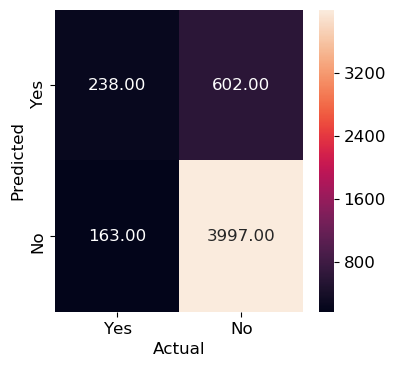
 
 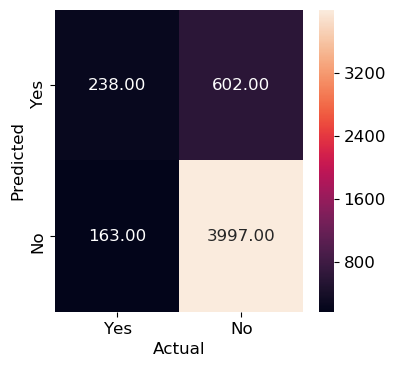
 
 
 best one
 
 {'colsample_bytree': 0.22,
 'gamma': 0.31,
 'learning_rate': 0.26,
 'max_depth': 6,
 'min_child_weight': 17.0,
 'min_samples_leaf': 2,
 'min_samples_split': 0,
 'n_estimators': 339,
 'subsample': 0.43}


In [ ]:
"""
Explore data
"""
df_1 = train_data[train_data['Default_ind']==1]
df_0 = train_data[train_data['Default_ind']==0]
cols = ['tot_credit_debt', 'avg_card_debt', 'credit_age', 'credit_good_age',
       'card_age', 'non_mtg_acc_past_due_12_months_num',
       'non_mtg_acc_past_due_6_months_num', 'mortgages_past_due_6_months_num',
       'credit_past_due_amount', 'inq_12_month_num', 'card_inq_24_month_num',
       'card_open_36_month_num', 'auto_open_ 36_month_num', 'uti_card',
       'uti_50plus_pct', 'uti_max_credit_line', 'uti_card_50plus_pct',
       'ind_acc_XYZ', 'rep_income',]
for col in cols:
    df_1[col].hist(bins=50)
    plt.title(col)
    plt.show()

In [ ]:
# for col in cols:
#     df_0[col].hist(bins=50)
#     plt.title(col)
#     plt.show()

In [ ]:
df_test_data_1 = test_data[test_data['Default_ind']==1]
df_test_data_0 = test_data[test_data['Default_ind']==0]
for col in cols:
    df_test_data_1[col].hist(bins=50)
    plt.title(col)
    plt.show()